In [0]:
# download data (-q is the quiet mode)
! wget -q https://www.dropbox.com/s/lhb1awpi769bfdr/test.csv?dl=1 -O test.csv
! wget -q https://www.dropbox.com/s/gudb5eunj700s7j/train.csv?dl=1 -O train.csv



traning 7631
testing 7632


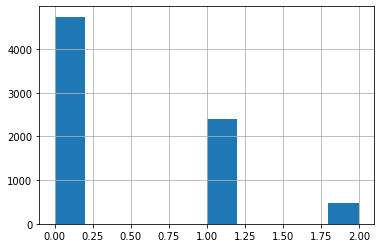

In [2]:
# Import the pandas library for useful data structures 
# and functionality for data analysis
import pandas as pd

# Read in the training set
Xy_train = pd.read_csv('train.csv', engine='python')
# Remove the target column from the data set for training
# (that's the column we're predicting, can't be in the training set)
X_train = Xy_train.drop(columns=['price_rating'])
# Extract the target column from the dataset
y_train = Xy_train[['price_rating']]

# Prints the number of entries in the training set
print('traning', len(X_train))
# Histogram plot of the different classes in our target attribute
Xy_train.price_rating.hist()

# Read in the test set
X_test = pd.read_csv('test.csv', engine='python')

# Extract the unique ID for each sample from the testing dataset
# (this is used for submissions to kaggle)
testing_ids = X_test.Id
# Output the number of samples in the test set
print('testing', len(X_test))


In [0]:
# model training and tuning
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier

# Set random generator to produce consistent random values
np.random.seed(0)

# Identify the numeric features in the dataset used in the model
numeric_features = ["latitude", "longitude", "accommodates", "bathrooms", 
                    "bedrooms", "beds", "square_feet","guests_included", 
                    "number_of_reviews", "review_scores_accuracy", 
                    "review_scores_cleanliness", "review_scores_checkin", 
                    "review_scores_communication", "review_scores_location", 
                    "review_scores_value", "reviews_per_month"]

# Simple imputer that replaces NaN values with the median of all other existing
# values in the column. Scaler takes feature values and scales them to unit 
# variance and mean of 0. Added to a Pipeline object to be used later
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Identify the categorical features to be used in the model
categorical_features = ["host_is_superhost", "property_type",
                        "bed_type", "is_business_travel_ready"]

# Apply impute (as described above) with default value "missing". Then performs
# one hot encoding, which takes possible categorical feature values and splits
# them into columns with either 1 or 0 (present or not present). If we were
# to just use label encoding, then our model would infer that the higher
# the categorical value the better (which is certainly not the case) 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Apply relevant pipeline operations to each of the column types (i.e. apply
# the categorical_transformer to the list of categorical columns, ...)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Regression pipeline for training the XGBoost ensemble. First step of the 
# pipeline is to apply the preprocessing steps, then to train the regression
# whose objective function to optimize is softmax multi: means do multi-class
# classification
regr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', XGBClassifier(
                          objective='multi:softmax', seed=1))])

# Syntax to unpack the column values (*numeric_features). Takes the list of
# column values and turns them into an argument list to index data from our
# X_train and X_test data sets (take only the columns we want)
X_train = X_train[[*numeric_features, *categorical_features]]
X_test = X_test[[*numeric_features, *categorical_features]]

# `__` denotes attribute 
# (e.g. regressor__n_estimators means the `n_estimators` param for `regressor`
#  which is our xgb). Passing in list give the possible values to be checked
#  in an exhaustive search.
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth':[10, 15, 20, 25, 30],
}

# Grid search performs an exhaustive search of the specified parameters from
# param_grid on a given model. Performed on the XGBoost model (regr) that we 
# specified above. Performs 5-fold cross validation, scores function based
# on the accuracy (f-score), and runs 2 jobs in parallel to complete the task.
# After setting up model, performs fit to run parameter optimization for the 
# model. Verbose 3 just means there's a verbose output when running (the 
# higher the parameter value, the more messages)
grid_search = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='accuracy')

# Parameter optimization and model fitting
grid_search.fit(X_train, y_train)

# Output the best accuracy from the model fit on training
print('best score {}'.format(grid_search.best_score_))

In [0]:
# Prediction & generating the submission file
y_pred = grid_search.predict(X_test)
pd.DataFrame(
    {'Id': testing_ids, 'price_rating':y_pred}).to_csv('sample_submission.csv', index=False)